In [49]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label
        self._backward = lambda: None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * self.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out

    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (- other)

    def __radd__(self, other):
        return self + other    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [44]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [46]:
a = Value(2.0, label='a')
b = Value(-4.0, label='b')
d = Value(2.5, label='d')
f = Value(6.0, label='f')

c = a + b; c.label = 'c'
e  = c + d; e.label = 'e'
g = e * f; g.label = 'g'
L = g.tanh(); L.label = 'L'


In [47]:
L.backward()

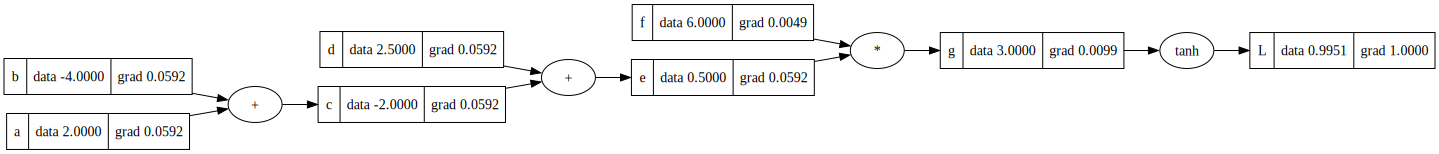

In [48]:
draw_dot(L)

In [80]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = [p for n in self.neurons for p in n.parameters()]
        return params
    
class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params
        

x = [2, 4, 6]
nn = MLP(3, [4,4,1])
nn(x)

Value(data=-0.7877412905649875)

In [81]:
len(nn.parameters())

41

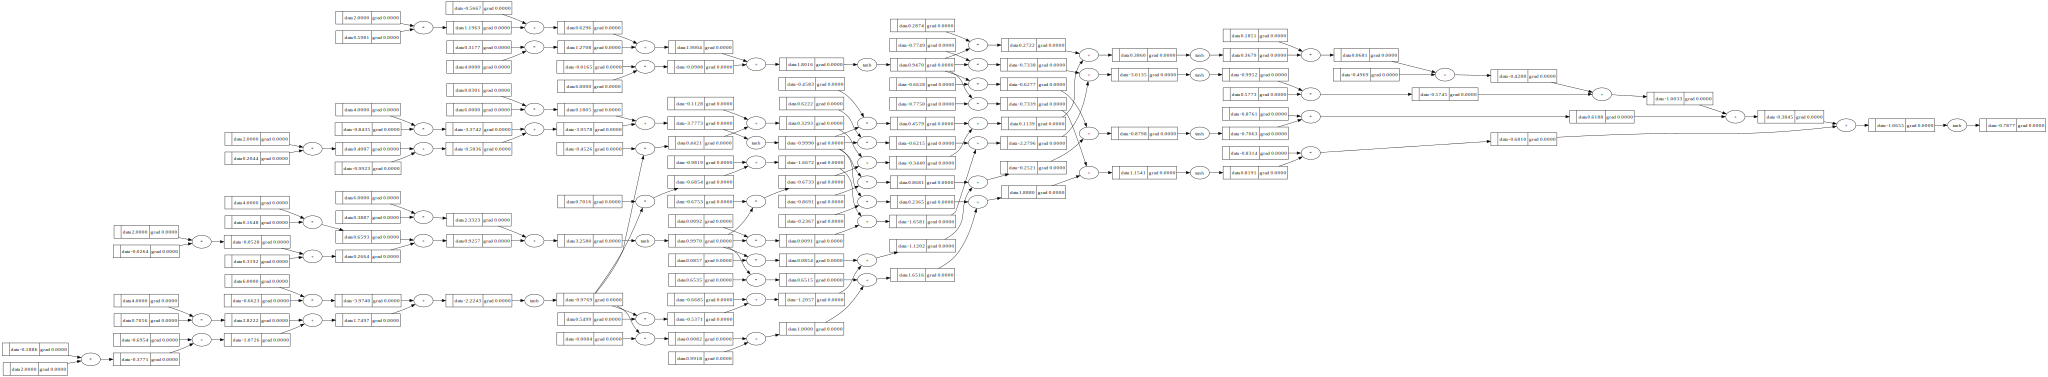

In [82]:
draw_dot(nn(x))

In [83]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, 1, -1]
]

ys = [1, -1, -1, 1]
ypred = [nn(x) for x in xs]
ypred

[Value(data=-0.9329499535361232),
 Value(data=-0.5126652939778439),
 Value(data=-0.9297065002570767),
 Value(data=-0.9422203615331985)]

In [84]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.750951747429259)

In [85]:
loss.backward()

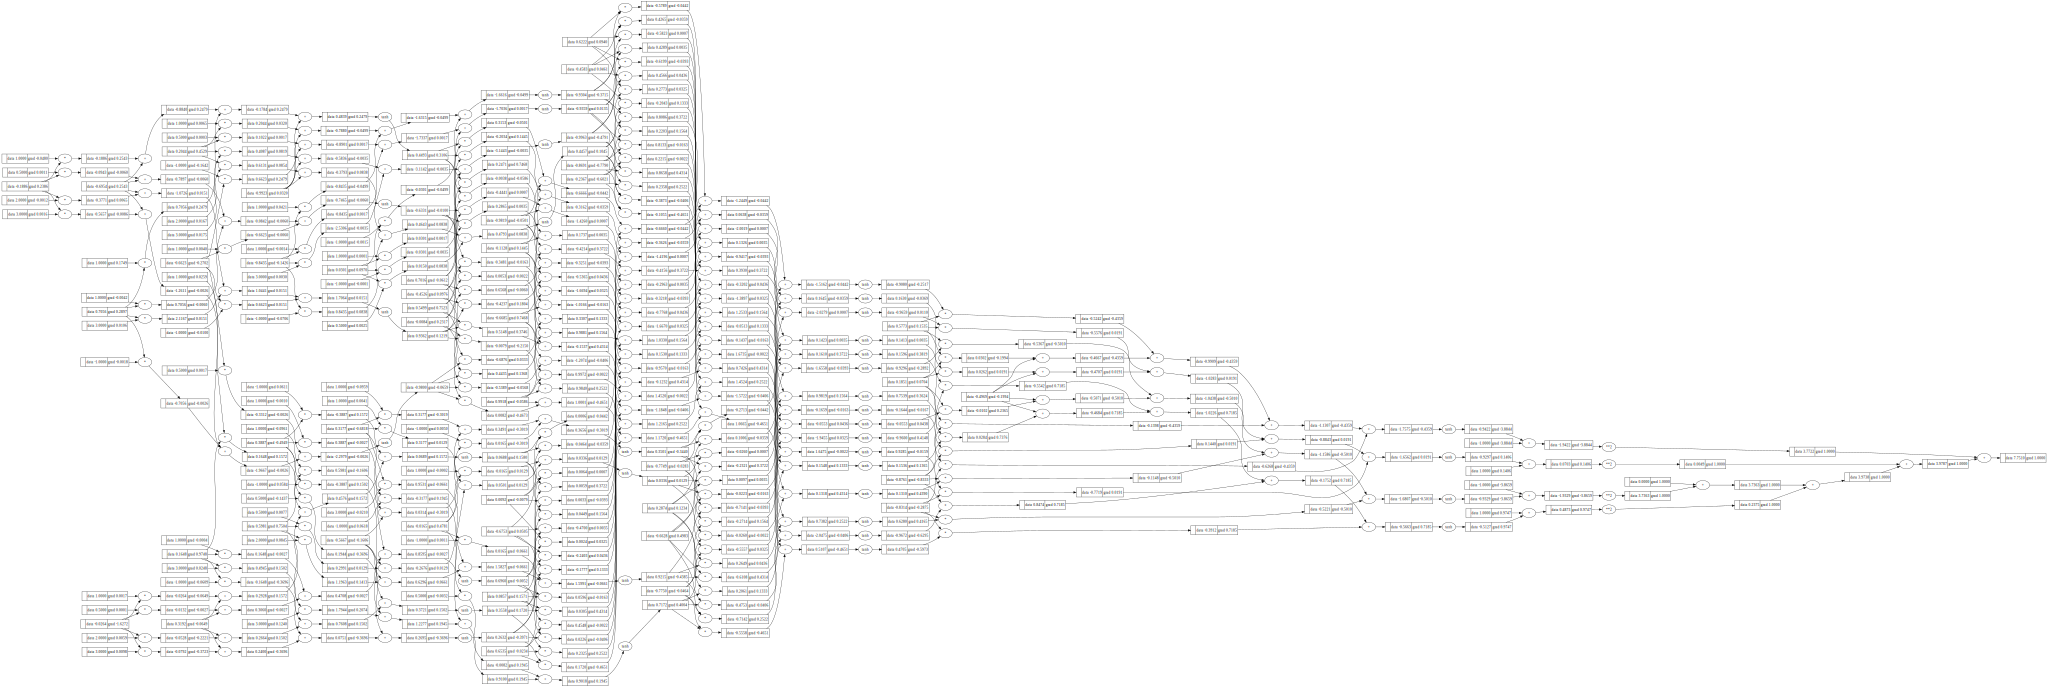

In [86]:
draw_dot(loss)

In [87]:
train_steps  = 10

for k in range(train_steps):

    # forward pass
    ypred = [nn(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in nn.parameters():
        p.grad = 0.0
    loss.backward()

    # gradient update
    for p in nn.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 7.750951747429259
1 7.341345091276685
2 5.250212146384534
3 1.5084791654241472
4 1.064848948470777
5 0.6708596103484556
6 0.39966155373280743
7 0.31388849263569346
8 0.2536337883681262
9 0.22437207648781737
